In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

In [1]:
import sys

sys.path.append("../../")
from src.config import *

In [6]:
def build_category_graph(categories):
    """
    Build the category graph, starting from the DataFrame extracted by processing dumps
    """
    categories = categories.set_index("title")
    # Build DiGraph from adjacency matrix
    G = nx.DiGraph(categories.parents.to_dict())
    nx.set_node_attributes(
        G,
        dict(
            zip(
                categories.index,
                categories[["id", "hiddencat"]].to_dict(orient="records"),
            )
        ),
    )
    depth = {
        node: len(sps)
        for node, sps in nx.shortest_path(G, target="CommonsRoot").items()
    }
    nx.set_node_attributes(G, depth, name="depth")
    return G

In [4]:
categories = pd.read_parquet(CATEGORIES_PATH)
categories.head()

,id,title,parents,hiddencat,childs
0,51586720,"'s-Gravelandse Veer 9, Amsterdam","['s-Gravelandseveer, Amsterdam, Rijksmonumente...",False,None
1,76297768,"'s-Gravenhekje 2, Amsterdam","[Rijksmonumenten in Amsterdam-Centrum, 's-Grav...",False,None
2,11456822,'t Oude Huis Zoetermeer,"[Buildings in Zoetermeer, Rijksmonumenten in Z...",False,None
3,75625387,(315898) 2008 QD4,[Centaurs (minor planets)],False,None
4,106082675,(an) Schloßstraße 17 (Ruppertsberg),"[Cultural heritage monuments in Ruppertsberg, ...",False,None


In [7]:
G = build_category_graph(categories)

In [8]:
nx.info(G)

/tmp/ipykernel_1779420/1064119803.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(G)


'DiGraph with 11198639 nodes and 25056545 edges'

In [9]:
hiddencats = [
    node
    for node, hiddencat in nx.get_node_attributes(G, "hiddencat").items()
    if hiddencat
]
print(
    f"There are {len(hiddencats)} identified hidden categories, corresponding to the "
    + f"{len(hiddencats) / G.number_of_nodes() * 100 :.2f}% of all categories"
)

There are 137449 identified hidden categories, corresponding to the 1.23% of all categories


In [10]:
in_wiki_cats = [
    node for node, in_wiki in nx.get_node_attributes(G, "in_en_wiki").items() if in_wiki
]
print(
    f"There are {len(in_wiki_cats)} categories with images appearing in en.wiki, corresponding to the "
    + f"{len(in_wiki_cats) / G.number_of_nodes() * 100 :.2f}% of all categories"
)

There are 0 categories with images appearing in en.wiki, corresponding to the 0.00% of all categories


In [11]:
depth = nx.get_node_attributes(G, "depth")

In [12]:
print(
    f"There are {len(depth)} nodes connected to CommonsRoot, corresponding to the "
    + f"{len(depth) / G.number_of_nodes() * 100 :.2f}% of all categories"
)

There are 8643203 nodes connected to CommonsRoot, corresponding to the 77.18% of all categories


In [13]:
sorted(Counter(depth.values()).items(), key=lambda x: x[0])

[(1, 1),
 (2, 7),
 (3, 124),
 (4, 2970),
 (5, 200265),
 (6, 461658),
 (7, 1310077),
 (8, 2166280),
 (9, 2398036),
 (10, 1344399),
 (11, 493516),
 (12, 101010),
 (13, 27143),
 (14, 17819),
 (15, 17315),
 (16, 21900),
 (17, 25093),
 (18, 16345),
 (19, 17992),
 (20, 10133),
 (21, 1830),
 (22, 1390),
 (23, 1913),
 (24, 1602),
 (25, 2686),
 (26, 838),
 (27, 578),
 (28, 258),
 (29, 10),
 (30, 10),
 (31, 5)]

In [46]:
pd.Series(depth).describe()

count    8.643203e+06
mean     8.641837e+00
std      1.830149e+00
min      1.000000e+00
25%      8.000000e+00
50%      9.000000e+00
75%      9.000000e+00
max      3.100000e+01
dtype: float64

In [53]:
counts.sort_index().loc[5:12].sum()

0.9805671578001812

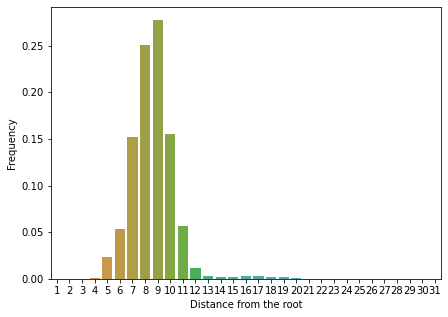

In [47]:
fig = plt.figure(figsize=(7, 5))
counts = pd.Series(depth).value_counts(sort=False, normalize=True)
sns.barplot(x=counts.index, y=counts.values)
plt.xlabel("Distance from the root")
plt.ylabel("Frequency")
plt.show()

In [19]:
not_connected_nodes = set(G.nodes) - set(depth.keys())

In [20]:
# Examples of nodes that cannot reach CommonsRoot
list(not_connected_nodes)[:10]

['Music events in 1892',
 '',
 'September 2014 Greece photographs',
 'October 2015 in Miyagi prefecture',
 '2001 in Bremen',
 'October 2013 in Europe',
 '1746 in Central America',
 'War in Afghanistan (2001-present) related operations outside of Afghanistan',
 'Military facilities of Macedonia',
 'WLM/7831959000']

Almost all those categories in reality are connected, but they have ancestors added via templates (ex. Virginia State Route 7298 or Religious organizations established in 1123). For now, we didn't manage to get the template expansion working, so categories added through templates are not available.

In [21]:
G.out_edges("Virginia State Route 7298")

OutEdgeDataView([])

In [23]:
leaf_it = (x for x in G.nodes() if G.in_degree(x) == 0)
wiki_leaf_it = (
    x for x in G.nodes() if G.in_degree(x) == 0 and G.nodes[x].get("in_en_wiki", 0)
)
nleaves = sum(1 for _ in leaf_it)
nleaves_wiki = sum(1 for _ in wiki_leaf_it)

print(
    f"There are {nleaves} leaf nodes, corresponding to the "
    + f"{nleaves / G.number_of_nodes() * 100 :.2f}% of all categories"
)

# print(f'There are {nleaves_wiki} leaf nodes containing images appearing in en.wiki, corresponding to the ' +
#       f'{nleaves_wiki / len(in_wiki_cats) * 100 :.2f}% of categories in en.wiki, to the ' +
#       f'{nleaves_wiki / nleaves * 100 :.2f}% of leaf nodes, and to the ' +
#       f'{nleaves_wiki / G.number_of_nodes() * 100 :.2f}% of all categories')

There are 6934423 leaf nodes, corresponding to the 61.92% of all categories


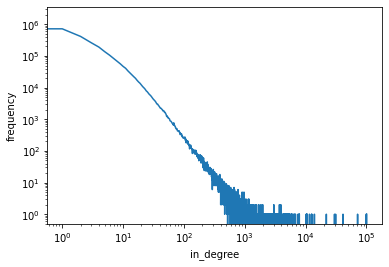

In [61]:
counts = Counter(d for n, d in G.in_degree())
in_degree_freq = [counts.get(i, 0) for i in range(1, max(counts) + 1)]

plt.loglog(range(len(in_degree_freq)), in_degree_freq)
plt.xlabel("in_degree")
plt.ylabel("frequency")
plt.show()

In [72]:
top_ideg = sorted(list(G.in_degree()), key=lambda x: x[1], reverse=True)
top_ideg[:15]

[('Aircraft by registration', 100803),
 ('Surnames', 99634),
 ('Ships by name (flat list)', 71579),
 ('Books in Japanese', 41223),
 ('People by name', 31173),
 ('Books in Chinese', 29868),
 ('Ships by IMO number', 21943),
 ('Aircraft registered in the United States (100-999)', 13963),
 ('Male names', 12683),
 ('Graves in the Père-Lachaise Cemetery', 12536),
 ('Politicians of the United States by name', 11591),
 ('Inscriptions in the Père-Lachaise Cemetery in French', 10565),
 ('Sportspeople from the United States by name', 10550),
 ('Aircraft registered in the United Kingdom', 10446),
 ('Deaths in Paris', 10230)]

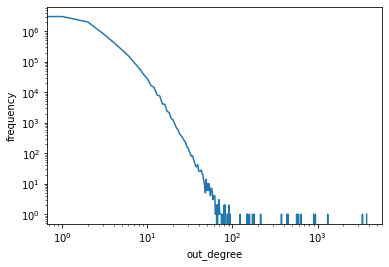

In [63]:
counts = Counter(d for n, d in G.out_degree())
out_degree_freq = [counts.get(i, 0) for i in range(1, max(counts) + 1)]

plt.loglog(range(len(out_degree_freq)), out_degree_freq)
plt.xlabel("out_degree")
plt.ylabel("frequency")
plt.show()

In [71]:
top_odeg = sorted(list(G.out_degree()), key=lambda x: x[1], reverse=True)
top_odeg[:15]

[('Dodecalingual Arabic-Armenian-Chinese-Danish-Dutch-English-French-German-Greek-Hindi-Russian-Swedish signs',
  3767),
 ('Dodecalingual Chinese-Dutch-English-French-German-Greek-Hungarian-Italian-Russian-Serbo-Croatian-Spanish-Swedish signs',
  3365),
 ('Undecalingual Chinese-Czech-English-French-German-Hungarian-Italian-Japanese-Korean-Russian-Spanish signs',
  1315),
 ("Decalingual Arabic-Burmese-Chinese-French-Ge'ez-Hebrew-Hindi-Japanese-Korean-Russian signs",
  942),
 ('Decalingual Chinese-English-French-Georgian-German-Hebrew-Polish-Russian-Tatar-Ukrainian signs',
  901),
 ('Decalingual Czech-Dutch-English-French-German-Italian-Polish-Russian-Slovak-Spanish signs',
  639),
 ('Decalingual Arabic-Chinese-English-French-German-Italian-Japanese-Portuguese-Russian-Spanish signs',
  597),
 ('Decalingual Chinese-Czech-English-French-German-Hebrew-Hungarian-Japanese-Polish-Russian signs',
  568),
 ('Novelingual Chinese-English-Hindi-Japanese-Khmer-Korean-Spanish-Tagalog-Vietnamese signs

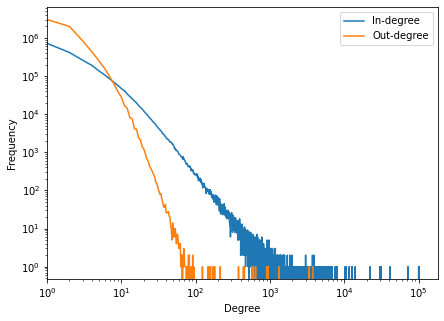

In [75]:
plt.rcParams.update({"font.size": 22})

fig = plt.figure(figsize=(7, 5))
plt.loglog(range(len(in_degree_freq)), in_degree_freq)
plt.loglog(range(len(out_degree_freq)), out_degree_freq)
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.legend(["In-degree", "Out-degree"])  # , prop={'size': 15})
plt.xlim(left=1)
plt.savefig("plots/degree-distribution.pdf")
plt.show()

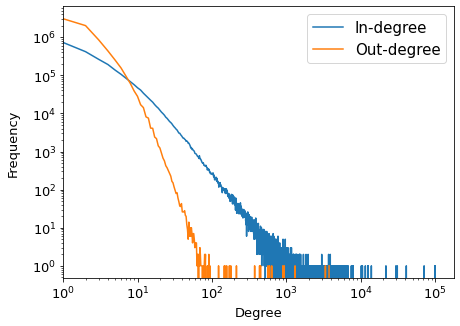

In [83]:
plt.rcParams.update({"font.size": 13})

fig = plt.figure(figsize=(7, 5))
plt.loglog(range(len(in_degree_freq)), in_degree_freq)
plt.loglog(range(len(out_degree_freq)), out_degree_freq)
plt.xlabel("Degree")
plt.ylabel("Frequency", labelpad=12)
plt.legend(["In-degree", "Out-degree"], prop={"size": 15})
plt.xlim(left=1)
plt.savefig("plots/degree-distribution.pdf")
plt.show()